In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
import string

In [2]:
df = pd.read_json('/Users/camilogarciatorres/Desktop/wj-tests/Datascience/data/clasificador/clasificador.json')

In [3]:
df.head()

text age_range
0  @gusgomez1701 @YaKoDj @TropiBogota @Apple @Hua...     50-64
1  @jlmorales5 Sol Campbell, Per Mertesacker, Ver...     13-17
2  LA DIGNIDAD COMIENZA POR RESPETAR LA VIDA Y NO...     18-24
3                                    @munqueik roba3     18-24
4                                     Necesito ayuda     18-24

In [4]:
df.shape

(30000, 2)

# EDA

Primero haremos un poco de exploratory analysis (Revisar nulls, duplicates y distribucion de datos).

In [5]:
df.dtypes

text         object
age_range    object
dtype: object

In [6]:
df.describe()

text age_range
count                   30000     30000
unique                  29951         6
top     @oracion_milagro Amén     35-49
freq                       22      8517

As we can see from the description, not all the tweets are unique. This can mean two possibilities, the first one is that there are some duplicate tweets or there are simply different users that texted the same thing (this can be more common in groups or places). With the infomation we have we can not infer if it is the first of the second case. 
Now we will explore duplicates

In [7]:
df.text.isnull().values.any()

False

In [8]:
df.age_range.isnull().values.any()

False

It seems there isn't any nan values in the data. Now we are going to see if there are some duplicate values. For the age column, it is obvious that there can be repeted age values. We will check then if there are any rows duplicated (both age and text).

In [9]:
df.duplicated().any() 

True

In [10]:
duplicate = df[df.duplicated()]
duplicate

text age_range
3096   seu perfil foi visto por 6 pessoas nas últimas...     18-24
5028                               @oracion_milagro Amén     50-64
5521                               @oracion_milagro Amén     50-64
6039                               @oracion_milagro Amén     65-xx
7878                               @oracion_milagro Amén     50-64
7942                               @oracion_milagro Amén     65-xx
10065                              @oracion_milagro Amén     65-xx
11220                              @oracion_milagro Amén     50-64
11818                              @oracion_milagro Amén     65-xx
12507                              @oracion_milagro Amén     65-xx
12925                              @oracion_milagro Amén     65-xx
12976                              @oracion_milagro Amén     50-64
13928                              @oracion_milagro Amén     50-64
15269                      @serpra72 @ExtratiempoCO Amén     50-64
15779  one person unfollowed me // automatically chec...     50-64
16411  @Torre2524 #CamilaCabello #BestSoloBreakout #i...     18-24
16424                                    @PLinero Amén💪😷     35-49
16990                              @oracion_milagro Amén     65-xx
17001                                @DiosUneSusHijos 🙏🙏     35-49
18283  última atualização de visitantes do meu perfil...     18-24
19843                              @oracion_milagro Amén     65-xx
20126                                @Pontifex_es Amén💪😷     35-49
20755  seu perfil foi visto por 6 pessoas nas últimas...     18-24
20840                               @OracionParaHoy Amén     65-xx
23442  última atualização de visitantes do meu perfil...     18-24
23726  perfil visualizado por 8 pessoas https://t.co/...     18-24
24014                                  @DanielSamperO Yo     35-49
24119                              @oracion_milagro Amén     65-xx
24274                              @oracion_milagro Amén     35-49
24424  @MauroRey91 Eso!!! Asi es mi títere clavado! H...     35-49
24963                              @oracion_milagro Amén     50-64
25318  @MauroRey91 Eso!!! Asi es mi títere clavado! H...     35-49
26098                            @oracion_milagro Amén 🙏     65-xx
26205                                      @Dios733 Amén     50-64
26405  No me han retwitteado ningún Tweet [últimas 24...     18-24
26965                                @Bibliaenlinea Amen     50-64
27352                               @AvivaMonterrey Amén     50-64
28010  No me han retwitteado ningún Tweet [últimas 24...     18-24
28070                               @OracionParaHoy Amén     65-xx
28322  @MauroRey91 Eso!!! Asi es mi títere clavado! H...     35-49
28452                              @oracion_milagro Amén     65-xx
29731                              @oracion_milagro Amén     50-64
29765                                 #NuevaFotoDePerfil     18-24

In [11]:
duplicate.shape

(43, 2)

As we can see from the tweets that are equal, we can not define with the information we have if they are from the same person or not. One possibility here is to drop the duplicated tweets but in this case I am going to keep them because they are not too many. If there were a bigger percentace we would think twice in removing the words because they could overfit the model. Next we will see the age distribution:

Text(0.5, 1.0, 'Histogram of ages')

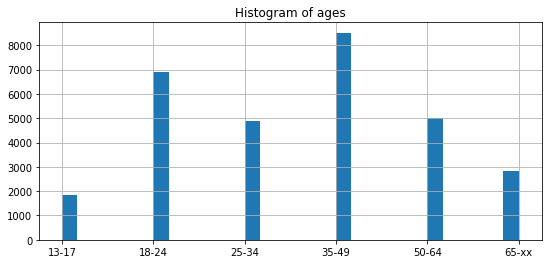

In [12]:
df.sort_values(by=['age_range']).age_range.hist(bins=30, figsize=(9,4))
plt.title('Histogram of ages')

From the age distribution we can see that most of the tweets are from poeple aged between 35-95 followed by 18-24 and the least amount of tweets are made by the 13-17 group. The distributiion of ages is a little uneven, this can be a problem because the model will have a harder time predicting group ages with lower numbers of tweets. Now we are going to see the distribution of number of words per tweet:

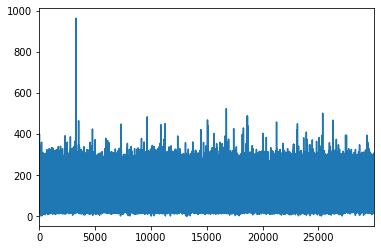

In [13]:
df['length'] = df['text'].apply(len)
df.length.plot()

It seems that most of the tweets are in the range of 0 to 300 of string characters. There is one tweet with a lot of text, we can check it out to see if we want to keep it. 

Finaly we can see the distribution of tweet lenght against age, this distribution shows that the older the person the larger they write tweets.

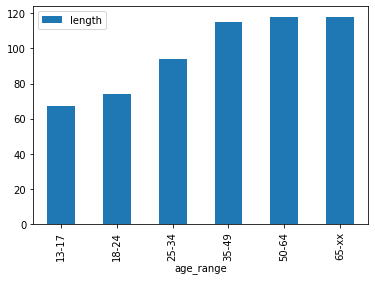

In [14]:
df.groupby(['age_range'])['length'].mean().to_frame().plot(kind="bar")

In [15]:
df.dtypes

text         object
age_range    object
length        int64
dtype: object

We are done with the exploratory analysis. We will continiue with NLTK.

# NLKT

En esta sección eliminamos los stopwords en español. Esta es una manera de preparar el texto para cuando entrenemos los modelos. Tambien es posible que sea mejor crear nuestro propio diccionario de stopwords ya que el que aparece por default en nltk puede que no sea tan bueno.

In [16]:
import nltk
from nltk.tokenize import word_tokenize
stop_words = nltk.corpus.stopwords.words('spanish')

df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
#df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (string.punctuation)]))

# Trainning Models

En esta sección solo entrenaremos 2 tipos de modelos. Despues de revisar algunos ejemplos, utilizaremos el multinomial Naive Baise y un clasificador SVM,

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.age_range, test_size=0.33, random_state=10)

In [18]:
mnb_model = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                      ('clf', MultinomialNB()),])

mnb_model = mnb_model.fit(X_train, y_train)

In [19]:
predicted_mnb = mnb_model.predict(X_test)
accuracy_score1 = accuracy_score(y_test, predicted_mnb)
accuracy_score1

0.3877777777777778

In [20]:
svm_model = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                      ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',
                                            alpha=1e-3, random_state=42)), ])


svm_model = svm_model.fit(X_train, y_train)

In [21]:
predicted_svm = svm_model.predict(X_test)
accuracy_score2 = accuracy_score(y_test, predicted_svm)
accuracy_score2

0.4109090909090909

Como podemos ver, el modelo SVM se desempeño mejor que el modelo mnb. Sin embargo, un acurracy del 40% es un poco bajo. Por lo tanto utilizaremos GridSearch para hacer tunning a los hyperparametros de los modelos.

## GridSearch

In [22]:
from sklearn.model_selection import GridSearchCV
parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2)],
                  'tfidf__use_idf': (True, False),
                'clf-svm__alpha': (1e-2, 1e-3),
 }

grid_svm = GridSearchCV(svm_model, parameters_svm, n_jobs=-1)
grid_svm = grid_svm.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [23]:
grid_svm.best_score_
grid_svm.best_params_

{'clf-svm__alpha': 0.001, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}

In [24]:
svm_model2 = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
                    ('tfidf', TfidfTransformer(use_idf=True)),
                      ('clf', MultinomialNB(alpha=0.001)),])

svm_model2 = svm_model2.fit(X_train, y_train)

In [25]:
predicted_svm2 = svm_model2.predict(X_test)
accuracy_score3 = accuracy_score(y_test, predicted_svm2)
accuracy_score3

0.39444444444444443

In [26]:
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
               'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-2, 1e-3),}

grid_mnb = GridSearchCV(mnb_model, parameters, n_jobs=-1)
grid_mnb = grid_mnb.fit(X_train, y_train)
grid_mnb.best_score_
grid_mnb.best_params_

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'clf__alpha': 0.01, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 1)}

In [27]:
mnb_model2 = Pipeline([('vect', CountVectorizer(ngram_range=(1,1))),
                    ('tfidf', TfidfTransformer(use_idf=False)),
                      ('clf', MultinomialNB(alpha=0.01)),])

mnb_model2 = mnb_model2.fit(X_train, y_train)
predicted_mnb2 = mnb_model2.predict(X_test)
accuracy_score4 = accuracy_score(y_test, predicted_svm2)
accuracy_score4

0.39444444444444443

# Keras model

In [28]:

from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping


In [29]:
exclude = set(string.punctuation)

text = ' '.join(X_train)
text = ''.join(word for word in text if word not in exclude)

tokenized_words = nltk.word_tokenize(text)
count=pd.Series(tokenized_words).value_counts()
print("Number of unique words: ",len(count))

Number of unique words:  58769


In [30]:
distribution=X_train.str.split().str.len()
np.percentile(distribution, 80)

15.0

In [31]:
tokenizer = Tokenizer(num_words=30000)
tokenizer.fit_on_texts(X_train)

In [32]:
train_sequences=tokenizer.texts_to_sequences(X_train)
train_sequences=pad_sequences(train_sequences, value=22)

test_sequences=tokenizer.texts_to_sequences(X_test)
test_sequences=pad_sequences(test_sequences, value=22)


In [34]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
# transform data
ordinal_train = encoder.fit_transform(y_train.values.reshape(-1,1))
ordinal_test = encoder.fit_transform(y_test.values.reshape(-1,1))


train_labels = np.asarray(ordinal_train)
test_labels=np.asarray(ordinal_test)

In [35]:
model = Sequential()
model.add(Embedding(30000, 128, input_length=22))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(6, activation='sigmoid'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 22, 128)           3840000   
_________________________________________________________________
dense (Dense)                (None, 22, 64)            8256      
_________________________________________________________________
dense_1 (Dense)              (None, 22, 64)            4160      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
Total params: 3,852,806
Trainable params: 3,852,806
Non-trainable params: 0
_________________________________________________________________


In [37]:
model.fit(train_sequences, train_labels, validation_split=0.2, epochs=5)

Epoch 1/5
503/503 [==============================] - 28s 55ms/step - loss: 1.6536 - accuracy: 0.3128 - val_loss: 1.5295 - val_accuracy: 0.3766
Epoch 2/5
503/503 [==============================] - 22s 45ms/step - loss: 1.3392 - accuracy: 0.4742 - val_loss: 1.5440 - val_accuracy: 0.3948
Epoch 3/5
503/503 [==============================] - 27s 54ms/step - loss: 0.8651 - accuracy: 0.6880 - val_loss: 1.8197 - val_accuracy: 0.3731
Epoch 4/5
503/503 [==============================] - 24s 48ms/step - loss: 0.4485 - accuracy: 0.8542 - val_loss: 2.2572 - val_accuracy: 0.3537
Epoch 5/5
503/503 [==============================] - 21s 42ms/step - loss: 0.2357 - accuracy: 0.9261 - val_loss: 2.7259 - val_accuracy: 0.3455


In [38]:
predictions = np.argmax(model.predict(test_sequences), axis=1)
predictions

array([4, 5, 4, ..., 2, 4, 1])

In [39]:
accuracy_score5 = accuracy_score(test_labels, predictions)
accuracy_score5

0.3507070707070707

# Conclusiones

- El modelo de keras no funciono muy bien para clasificar el usuario, aunque falto realizar tunning a los parametros. 
- El modelo con mejor resultado fue el modelo SVM con 41%
- El grid search puede servir como solución para mejorar la eficiencia del modelo.
- Crear nuevas variables (como contar el numero de emoticones usados) puede servir como predictor de edad y mejorar el accurracy del modelo.
- Tambien falto explorar modelos mas complejos como boosting o stacking que pueden resultar en un aumento de accurracy.